In [4]:
#!/usr/bin/env python
# coding: utf-8

import cv2
import numpy as np
import os
import sys
import pandas as pd
from random import shuffle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets, models
from PIL import Image
import nibabel as nib
import time
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def create_paths(datapath):
    #     Create paths to all nested images
    imagepaths = []
    for root, dirs, files in os.walk(datapath, topdown=False):
        for name in files:
            imagepaths.append(os.path.join(root, name))
    return imagepaths

def get_label(imagepath, csvpath):
    #     Get the diagnosis label for path
    table = pd.read_csv(csvpath)
    idpath = imagepath.split('/')[13]
    img_id = idpath[idpath.find('_I') + 2:-4]
    group = table.loc[table['Image Data ID'] == int(
        img_id)]["Group"].reset_index(drop=True)[0]
    group_to_label = {'CN': 0, 'MCI': 2, 'AD': 1}
    label = group_to_label[group]
    return label

class ADNI(Dataset):
    def __init__(self, datapath, csvpath, labels = [0, 1, 2], transform=None):
        """
        Args:
            datapath (string): Directory with all the images.
            csvpath (string): Path to CSV
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        all_imagepaths = create_paths(datapath)[:-1]
        self.csvpath = csvpath
        self.imagepaths = [path for path in tqdm(all_imagepaths) if get_label(path, csvpath) in labels] 
        self.transform = transform

    def __len__(self):
        #         Returns the length of the dataset
        return len(self.imagepaths)

    def __getitem__(self, idx):
        #         Returns a tuple of the image and its group/label
        imgsize = 64

        if torch.is_tensor(idx):
            idx = idx.tolist()
        imagepath = self.imagepaths[idx]
        label = get_label(imagepath, csvpath)
        
        #         create imgbatch with three different perspectives
        imgbatch = []
        
        imgdata = nib.load(imagepath).get_fdata()
        if self.transform:
            imgdata = self.transform(imgdata)
            
        imgdata1 = cv2.resize(imgdata[imgdata.shape[0]//2, :, :], (imgsize, imgsize))
        imgdata1 = torch.from_numpy(imgdata1)
        imgdata1 = torch.stack([imgdata1, imgdata1, imgdata1], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        imgdata2 = cv2.resize(imgdata[:, imgdata.shape[0]//2, :], (imgsize, imgsize))
        imgdata2 = torch.from_numpy(imgdata2)
        imgdata2 = torch.stack([imgdata2, imgdata2, imgdata2], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        imgdata3 = cv2.resize(imgdata[:, :, imgdata.shape[0]//2], (imgsize, imgsize))
        imgdata3 = torch.from_numpy(imgdata3)
        imgdata3 = torch.stack([imgdata3, imgdata3, imgdata3], 0)
        imgbatch.append(imgdata1.reshape(3, imgsize, imgsize))
        
        sample = (imgbatch, torch.tensor(label))
        return sample

datapath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T"
csvpath = r"/media/swang/Windows/Users/swang/Downloads/ADNI1_Complete_1Yr_1.5T_7_08_2020.csv"
dataset = ADNI(datapath, csvpath, labels = [0, 1])

lengths = [
    int(len(dataset) * 0.8),
    int(len(dataset) * 0.1),
    int(len(dataset) * 0.1) + 1
]


trainset, valset, testset = random_split(dataset, lengths)
image_datasets = {'train': trainset, 'val': valset, 'test': testset}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}  


In [17]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

    
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 100)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in tqdm(dataloaders[phase], total = dataset_sizes[phase]//32+1):
                labels = labels.to(device)
            
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * 32
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_accuracy.append(epoch_acc)
                
            if phase == 'val':
                val_loss.append(epoch_loss)
                val_accuracy.append(epoch_acc)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [25]:
class old(nn.Module):
    def __init__(self):
        super(old, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64*16*3, 128)
        self.fc2 = nn.Linear(128, 2)
        self.drop1 = nn.Dropout(p=0.1)
        self.drop2 = nn.Dropout(p=0.5)
        
    def forward(self, x_batch):
#         x_batch always has length 3
        x_batch_conv = []
        for x in x_batch:
            x = x.to(device, dtype=torch.float) 
            x = self.pool(self.drop1(F.relu(self.conv1(x))))
            x = self.pool(self.drop1(F.relu(self.conv2(x))))
            x = self.pool(self.drop1(F.relu(self.conv3(x))))
            x = x.view(-1, 64*16)
            x_batch_conv.append(x)
            
        out = torch.cat(tuple(x_batch_conv), dim=-1)
        print(out.shape)
        out = self.drop2(F.relu(self.fc1(out)))
        out = self.fc2(out)
        print(out.shape)
        
        return out

In [26]:
model = old().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------------------------------------------------------------------------------------------------


torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])
torch.Size([32, 3072])
torch.Size([32, 2])


KeyboardInterrupt: 

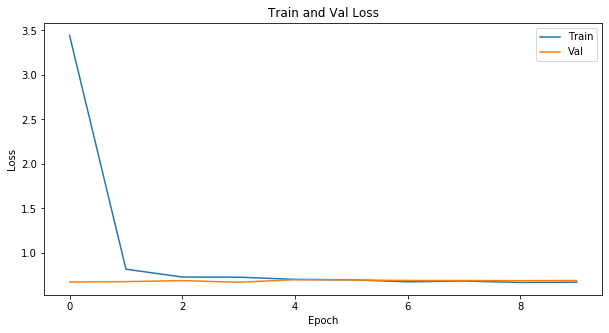

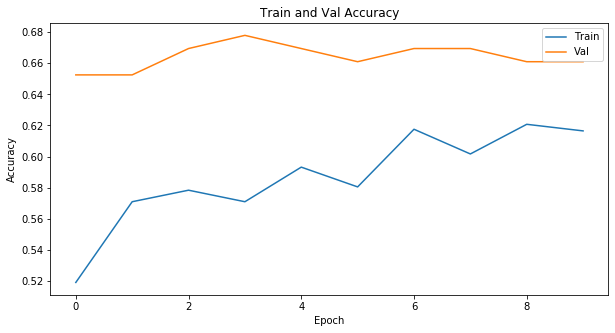

In [20]:
plt.figure(figsize=(10,5))
plt.title("Train and Val Loss")
plt.plot(train_loss,label="Train")
plt.plot(val_loss,label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Train and Val Accuracy")
plt.plot(train_accuracy,label="Train")
plt.plot(val_accuracy,label="Val")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()